# Hugging Face and Sagemaker: fine-tuning DistilBERT with Amazon Polarity dataset

## Introduction

In this demo, you will use the Hugging Faces `transformers` and `datasets` library with Amazon SageMaker to fine-tune a pre-trained transformer on binary text classification. In particular, you will use the pre-trained DistilBERT model with the Amazon Reviews Polarity dataset.
You will then deploy the resulting model for inference using SageMaker Endpoint.

### The model

You'll be using an offshoot of [BERT](https://arxiv.org/abs/1810.04805) called [DistilBERT](https://arxiv.org/abs/1910.01108) that is smaller, and so faster and cheaper for both training and inference. A pre-trained model is available in the [`transformers`](https://huggingface.co/transformers/) library from [Hugging Face](https://huggingface.co/).

### The data

The [Amazon Reviews Polarity dataset](https://github.com/dsk78/Text-Classification---Amazon-Reviews-Polarity) consists of reviews from Amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. It's avalaible under the [`amazon_polarity`](https://huggingface.co/datasets/amazon_polarity) dataset on [Hugging Face](https://huggingface.co/).

## Setup
_This notebook was tested in Amazon SageMaker Studio on a **ml.m5.large** instance with **Python 3 (Data Science)** kernel._

### Dependecies
First, you need to install the dependecies required.

In [1]:
#My code
# !pip install botocore==1.23.25
# !pip install torchtext

!pip install -qq "sagemaker>=2.48.0" --upgrade
!pip install -qq torch==1.7.1 --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers==4.6.1 "datasets[s3]"
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.25 requires botocore==1.23.25, but you have botocore 1.24.3 which is incompatible.
aiobotocore 1.2.2 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.24.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.76.0 requires boto3>=1.20.21, but you have boto3 1.16.43 which is incompatible.
awscli 1.22.25 requires botocore==1.23.25, but you have botocore 1.19.52 which is incompatible.
awscli 1.22.25 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.3.7 which is incompatible.


If you are running this on a SageMaker environment, make sure to reboot the Kernel via the dropdown menu at the top after you've installed the above dependencies.

### Development environment 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

## Set up SageMaker session and bucket

In [5]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::523843493491:role/service-role/AmazonSageMaker-ExecutionRole-20220211T001925
sagemaker bucket: sagemaker-us-east-1-523843493491
sagemaker session region: us-east-1


# Data preparation

The data preparation is straightforward as you're using the `datasets` library to download and preprocess the `
amazon_polarity` dataset directly from Hugging face. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job.

In [6]:
dataset_name = 'ag_news'

train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])
train_dataset = train_dataset.shuffle().select(range(5000)) # limiting the dataset size to speed up the training during the demo
test_dataset = test_dataset.shuffle().select(range(1000))

Using custom data configuration default
Reusing dataset ag_news (/home/ec2-user/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-5ce432807dc24b0c.arrow


In [7]:
print(train_dataset.column_names)

['text', 'label']


Let's have a look at en example from the training dataset. This allows us to understand what is the format that is expected by Hugging Face Transformers library for input.

In [8]:
train_dataset[0]

{'text': 'New portable dual-screen system from Nintendo has plenty of bells &lt;b&gt;...&lt;/b&gt; On Sunday, the video-game giant will introduce its latest innovation, the Nintendo DS, or dual screen, which gaming fanatics around the globe have been dying to get their hands on.',
 'label': 3}

The dataset is already well balanced

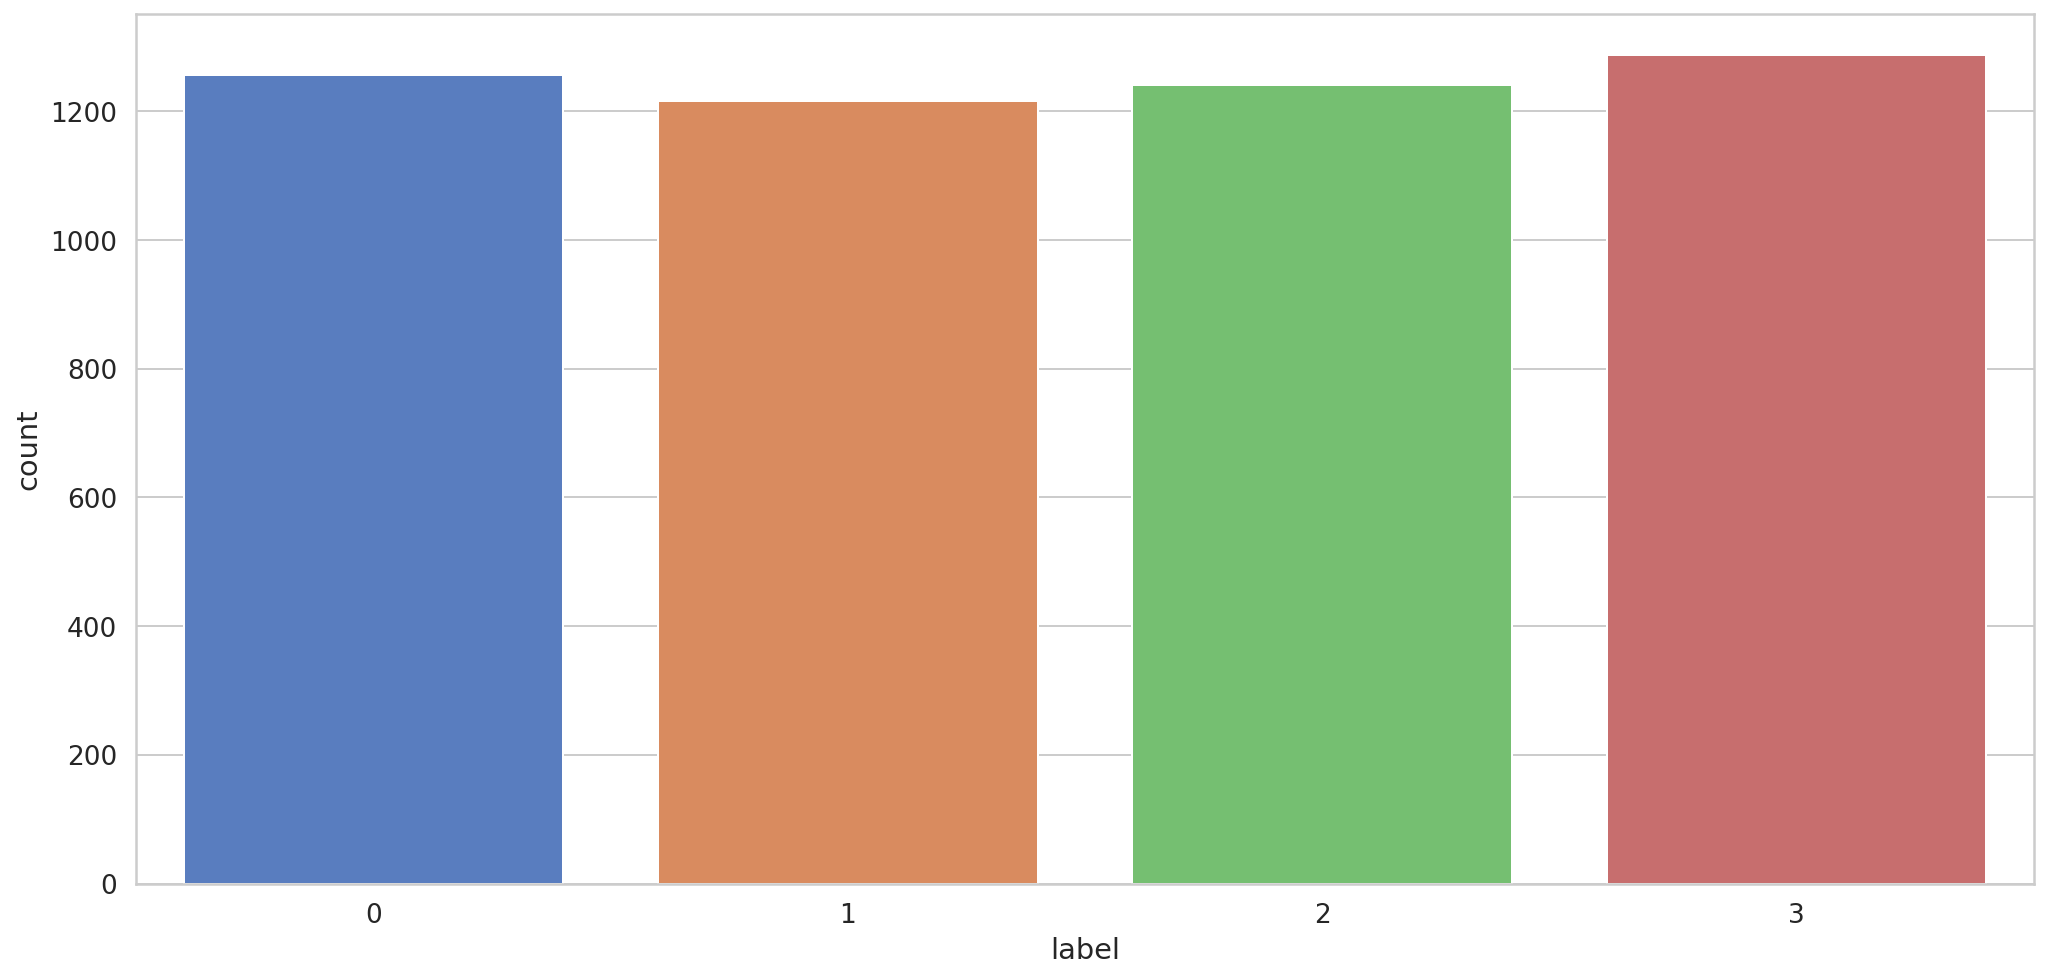

In [9]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

## Preparing the dataset to be used with PyTorch
You now need to convert the dataset for training. This means using a tokenizer and getting the PyTorch tensors. Hugging Face provides an [`AutoTokenizer`](https://huggingface.co/transformers/model_doc/auto.html#autotokenizer)

This downloads the tokenizer:

In [10]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

And this tokenize our training and testing datasets and then set them to the PyTorch format:

In [11]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-c6579182aa08259c.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

## Uploading the data to S3

Now that the data as been processed you can upload it to S3 for training

In [12]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-us-east-1-523843493491/samples/datasets/ag_news/train
Uploaded testing data to s3://sagemaker-us-east-1-523843493491/samples/datasets/ag_news/test


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job you need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator you define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in.
```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6',
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters)
```
When you create a SageMaker training job, SageMaker takes care of starting and managing all the required compute instances with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container local storage at `/opt/ml/input/data`. Then, it starts the training job by running. 
```python
/opt/conda/bin/python train.py --epochs 5 --model_name distilbert-base-cased --token_name distilbert-base-cased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. The training script expect the `HuggingFace` model and token name so it can retrieve them.

Sagemaker is providing other useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.

You can inspect the training script by running the next cell

In [13]:
!pygmentize ./scripts/train.py

"""
Training script for Hugging Face SageMaker Estimator
"""
import logging
import sys
import argparse
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--tokenizer_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_

## Creating an Estimator and start a training job

Name your training job so you can follow it:

In [14]:
model_name = 'distilbert-base-cased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-distilbert-base-cased-2022-02-19-16-56-02


In [15]:
hyperparameters={'epochs': 3,
                 'train_batch_size': 32,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
#                  'output-data-dir':'/opt/ml/checkpoints',
                 }

In [16]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [17]:
# My own custom comments
# !pip install -U sagemaker

In [18]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6', 
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,
                            max_run=36000, # expected max run in seconds
                        )

Starts the training job using the estimator fit function:

In [19]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path}, wait=False, job_name=training_job_name )

Wait for the training to finish. Training takes approximately 10 mins to complete.

In [20]:
sess.wait_for_job(training_job_name)
#/opt/conda/bin/python train.py --epochs 5 --model_name distilbert-base-cased --token_name distilbert-base-cased --train_batch_size 32


2022-02-19 16:56:03 Starting - Starting the training job.....
2022-02-19 16:56:30 Starting - Preparing the instances for training............
2022-02-19 16:57:35 Downloading - Downloading input data..
2022-02-19 16:57:50 Training - Downloading the training image........................................
2022-02-19 17:01:16 Training - Training image download completed. Training in progress.......
2022-02-19 17:01:54 Uploading - Uploading generated training model..........
2022-02-19 17:02:50 Failed - Training job failed


UnexpectedStatusException: Error for Training job finetune-distilbert-base-cased-2022-02-19-16-56-02: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train.py --epochs 3 --model_name distilbert-base-cased --tokenizer_name distilbert-base-cased --train_batch_size 32"
Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]Downloading: 100%|ââââââââââ| 411/411 [00:00<00:00, 373kB/s]
Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]Downloading:   2%|â         | 4.52M/263M [00:00<00:05, 45.1MB/s]Downloading:   4%|â         | 9.24M/263M [00:00<00:05, 45.8MB/s]Downloading:   5%|â         | 14.0M/263M [00:00<00:05, 46.4MB/s]Downloading:   7%|â         | 18.9M/263M [00:00<00:05, 46.9MB/s]Downloading:   9%|â         | 23.8M/263M [00:00<00:05, 47.5MB/s]Downloading:  11%|â         | 28.7M/263M [00:00<00:04, 48.1MB/s]Downloading:  13%|ââ        | 33.7M/263M [00:00<00:04, 48.7MB/s]Downloading:  15%|ââ        | 38.7M/263M [00:00<00:04, 49.0MB/s]Downloading:  17%|ââ        | 43.6M/263M [00:, exit code: 1

## Training metrics
You can now display the training metrics

In [ ]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

And plot the collected metrics

In [ ]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

# Endpoint

The `transformers pipelines` API allows you to use the `pipelines` features. 
Your inputs need to be defined in the `inputs` key.
If you want additional supported `pipelines` parameters you can add them in the `parameters` key.
The API is oriented at the API of the [🤗  Accelerated Inference API](https://api-inference.huggingface.co/docs/python/html/detailed_parameters.html), meaning your inputs need to be defined in the `inputs` key and if you want additional supported `pipelines` parameters you can add them in the `parameters` key. 

Below are a few request examples:

**text-classification request body**

```python
{
    "inputs": "Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days."
}
```

**question-answering request body**

```python
{
    "inputs": {
        "question": "What is used for inference?",
        "context": "My Name is Philipp and I live in Nuremberg. This model is used with sagemaker for inference."
    }
}
```

**zero-shot classification request body**

```python
{
    "inputs": "Hi, I recently bought a device from your company but it is not working as advertised and I would like to get reimbursed!\",
    "parameters": {
        "candidate_labels": [
            "refund",
            "legal",
            "faq"
         ]
    }
}
```

You can now proceed and create an endpoint with the trained model.

In [ ]:
predictor = huggingface_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large", endpoint_name=training_job_name)

After the endpoint is deployed you can run a prediction. `LABEL_0` indicates a negative review, `LABEL_1` indicates a positive review, and score corresponds to the probability of each label.

In [ ]:
data = {
   "inputs": [
       "Good product!",
       "Product is not good at all",
       "Idea is good, but product quality is poor"
   ]
}

# request
predictor.predict(data)

# Cleanup
After you are finished experimenting with this notebook, run the following cell to delete the predictor.

In [ ]:
predictor.delete_endpoint()